# Goal

* Analyze results from `atomIncorp_sampDepth` simulation

# Var

In [44]:
workDir = '/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_sampDepth/'

# Init

In [45]:
library(dplyr)
library(tidyr)
library(ggplot2)

# Load

In [46]:
# files on simulation accuracy
files = list.files(path=workDir, pattern='*-cMtx_byClass.txt', full.names=TRUE)
files

[1] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_sampDepth//DESeq2_multi-cMtx_byClass.txt"
[2] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_sampDepth//DESeq2-cMtx_byClass.txt"      
[3] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_sampDepth//heavy-cMtx_byClass.txt"       
[4] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_sampDepth//qSIP-cMtx_byClass.txt"

In [47]:
# combining files
df_byClass = list()
for (f in files){
    ff = strsplit(f, '/') %>% unlist
    fff = ff[length(ff)]
    df_byClass[[fff]] = read.delim(f, sep='\t')
}

df_byClass = do.call(rbind, df_byClass)
df_byClass$file = gsub('\\.[0-9]+$', '', rownames(df_byClass))
df_byClass$method = gsub('-.+', '', df_byClass$file)
rownames(df_byClass) = 1:nrow(df_byClass)

df_byClass %>% head(n=3)

,library,variables,values,percIncorp,subsample_size,rep,file,method
1,2,Sensitivity,NA,0,100,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi
2,2,Specificity,1,0,100,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi
3,2,Pos Pred Value,NA,0,100,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi


In [48]:
# renaming methods
rename = data.frame(method = c('DESeq2', 'DESeq2_multi', 'heavy', 'qSIP'), 
                   method_new = c('HR-SIP', 'MW-HR-SIP', 'Heavy-SIP', 'q-SIP'))

df_byClass = inner_join(df_byClass, rename, c('method'='method')) %>%
    select(-method) %>%
    rename('method' = method_new) 

df_byClass %>% head(n=3)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

,library,variables,values,percIncorp,subsample_size,rep,file,method
1,2,Sensitivity,NA,0,100,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP
2,2,Specificity,1,0,100,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP
3,2,Pos Pred Value,NA,0,100,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP


Warning message:
“Removed 64 rows containing missing values (geom_pointrange).”

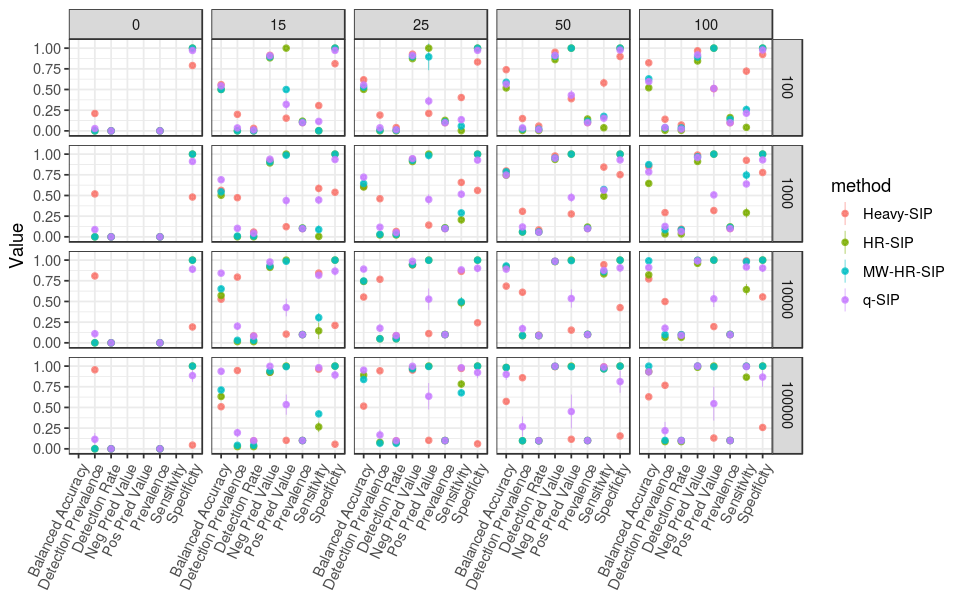

In [49]:
# summarize by SIPSim rep & library rep
df_byClass.s = df_byClass %>%
    group_by(method, percIncorp, subsample_size, variables) %>%
    summarize(mean_value = mean(values, na.rm=TRUE),
              sd_value = sd(values, na.rm=TRUE))

# plotting
options(repr.plot.width=8, repr.plot.height=5)
p = ggplot(df_byClass.s, aes(variables, mean_value, color=method,
                         ymin=mean_value-sd_value,
                         ymax=mean_value+sd_value)) +
    geom_pointrange(alpha=0.8, size=0.2) +
    labs(y='Value') +
    facet_grid(subsample_size ~ percIncorp) +
    theme_bw() +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=65, hjust=1)
    )
plot(p)

Warning message:
“Removed 32 rows containing missing values (geom_point).”Warning message:
“Removed 32 rows containing missing values (geom_linerange).”Warning message:
“Removed 4 rows containing missing values (geom_path).”

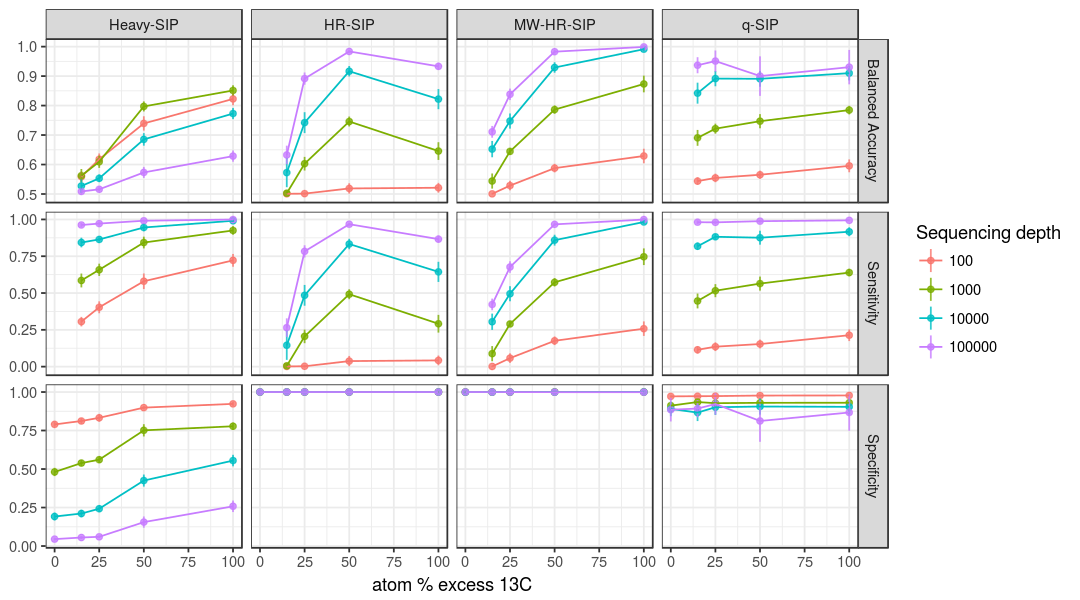

In [50]:
# summarize by SIPSim rep & library rep
vars = c('Balanced Accuracy', 'Sensitivity', 'Specificity')
df_byClass.s.f = df_byClass.s %>%
    filter(variables %in% vars) %>%
    ungroup() %>%
    mutate(subsample_size = subsample_size %>% as.character,
           subsample_size = subsample_size %>% reorder(subsample_size %>% as.numeric))


# plotting
options(repr.plot.width=9, repr.plot.height=5)
p.pnt = ggplot(df_byClass.s.f, aes(percIncorp, mean_value, 
                           color=subsample_size, 
                           group=subsample_size,
                           ymin=mean_value-sd_value,
                           ymax=mean_value+sd_value)) +
    geom_point(alpha=0.8) +
    geom_linerange(alpha=0.8, size=0.5) +
    geom_line() +
    scale_color_discrete('Sequencing depth') +
    labs(x='atom % excess 13C') +
    facet_grid(variables ~ method, scale='free_y') +
    theme_bw() +
    theme(
        axis.title.y = element_blank()
    )
plot(p.pnt)